### Install libraries if not already installed and push the data in mysql server with properly handling null values

In [1]:
#pip install mysql-connector-python
#pip install pandas
#pip install numpy
#pip install matplotlib
#pip install seaborn

In [ ]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv', 'order_items.csv')# Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='1234',
    database='e_commerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/nakul/Desktop/SQL Project/e-commerce project/Tables'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

### Connect again to server and define the cursor to run SQL queries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector


db = mysql.connector.connect(host = "localhost",
                            username = "root",
                            password = "1234",
                            database = "e_commerce")

cur = db.cursor()

### How sql query is used in python code
#### Step 1: Writing a query of SQL in pyhton in and saving it's name as query
query = """ select distinct customer_city from customers """ 

#### Step 2:Executing the query
cur.execute(query) 

#### Step 3:fetching the output of query and saving it in name = data
data = cur.fetchall() 

#### Step 4:creating a pandas dataframe of output to view it in proper manner in python output
df = pd.DataFrame(data) 

#### Step 5:viewing the output dataframe
df 

# Basic Queries

## 1. List all unique cities where customers are located. 


In [3]:
query = """ SELECT DISTINCT customer_city
FROM customers; 
 """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["cities"])
df

,cities
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
...,...
4114,siriji
4115,natividade da serra
4116,monte bonito
4117,sao rafael


## 2. Count the number of orders placed in 2017. 

In [4]:
query = """ SELECT COUNT(order_id) AS num_orders_2017
FROM orders
WHERE YEAR(order_purchase_timestamp) = 2017; """

cur.execute(query)

data = cur.fetchall()

print(f"Total orders placed in 2017 are: {data[0][0]}")

Total orders placed in 2017 are: 45101


## 3. Find the total sales per category

In [5]:
# if we want to include shipping cost as well

query = """ SELECT p.product_category AS product_category, ROUND(SUM(oi.price + oi.freight_value),2)
AS category_sales -- if we want to include shipping cost as well
FROM products p
JOIN order_items oi ON oi.product_id = p.product_id
GROUP BY p.product_category
ORDER BY category_sales DESC;"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["product_category", "category_sales"])
df

,product_category,category_sales
0,HEALTH BEAUTY,1441248.07
1,Watches present,1305541.61
2,bed table bath,1241681.72
3,sport leisure,1156656.48
4,computer accessories,1059272.40
...,...,...
69,flowers,1598.91
70,House Comfort 2,1170.58
71,cds music dvds,954.99
72,Fashion Children's Clothing,665.36


In [6]:
# if we don't want to include shipping cost

query = """SELECT p.product_category AS product_category, ROUND(SUM(oi.price),2) AS
category_sales -- if we don't want to include shipping cost
FROM products p
JOIN order_items oi ON oi.product_id = p.product_id
GROUP BY p.product_category
ORDER BY category_sales DESC; """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["product_category", "category_sales"])
df

,product_category,category_sales
0,HEALTH BEAUTY,1258681.34
1,Watches present,1205005.68
2,bed table bath,1036988.68
3,sport leisure,988048.97
4,computer accessories,911954.32
...,...,...
69,flowers,1110.04
70,House Comfort 2,760.27
71,cds music dvds,730.00
72,Fashion Children's Clothing,569.85


## 4. Calculate the percentage of orders that were paid in installments. 

In [7]:
query1 = """SELECT
COUNT((CASE WHEN payment_installments > 1 THEN order_id END))*100/COUNT(*) AS
perc_of_installment_orders
FROM payments;"""


cur.execute(query1)

data1 = cur.fetchall()


print(f"The percentage of orders that were paid in installments is: {data1[0][0]}% (for not including '1' in column 'payment_installments')")


The percentage of orders that were paid in installments is: 49.4176% (for not including '1' in column 'payment_installments')


In [8]:
query2 = """SELECT -- Considering payment_installments = 1 as installment as there are few rows with payment_installments = 0
COUNT((CASE WHEN payment_installments >= 1 THEN order_id END))*100/COUNT(*) AS perc_of_installment_orders
FROM payments;"""

cur.execute(query2)
data2 = cur.fetchall()
print(f"The percentage of orders that were paid in installments is: {data2[0][0]}% (for not including '1' in column 'payment_installments')")

The percentage of orders that were paid in installments is: 99.9981% (for not including '1' in column 'payment_installments')


## 5. Count the number of customers from each state

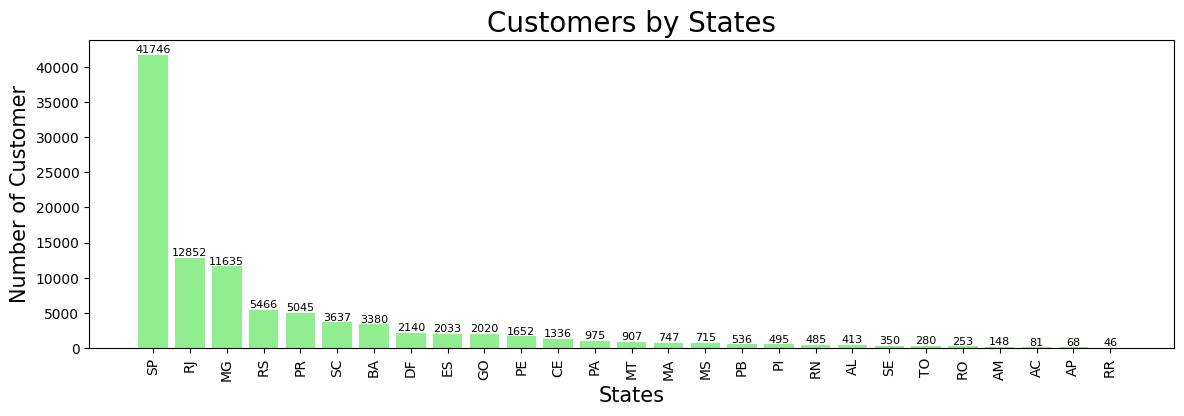

In [9]:
query = """SELECT 
customer_state, COUNT(customer_id) AS num_customers
FROM customers
GROUP BY customer_state
ORDER BY num_customers DESC;"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["state", "customer_count" ])
df = df.sort_values(by = "customer_count", ascending= False)

plt.figure(figsize = (14,4))
barplot1 = plt.bar(df["state"], df["customer_count"], color="lightgreen")
plt.bar_label(barplot1, size = 8)
plt.xticks(rotation = 90)
plt.xlabel("States", size = 15)
plt.ylabel("Number of Customer", size = 15)
plt.title("Customers by States", size = 20)
plt.show()

# Intermediate Queries

## 1. Calculate the number of orders per month in 2018. 


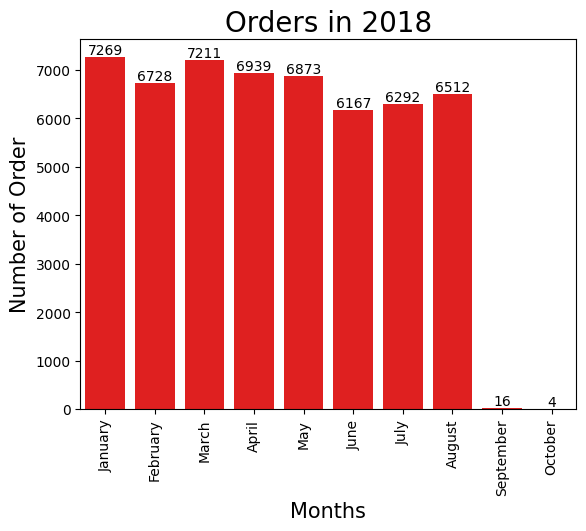

In [10]:
query = """WITH num_orders_2018 AS(
	SELECT 
	MONTHNAME(order_purchase_timestamp) AS month_of_2018, 
	MONTH(order_purchase_timestamp) AS month_num, 
	COUNT(order_id) AS num_orders
	FROM orders
	WHERE YEAR(order_purchase_timestamp) = 2018
	GROUP BY month_of_2018, month_num
	ORDER BY month_num
)
SELECT month_of_2018, num_orders 
FROM num_orders_2018;"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["month_of_2018", "num_orders"])

ax = sns.barplot(x = df["month_of_2018"],y =  df["num_orders"], data = df, color = "red")
ax.bar_label(ax.containers[0])
plt.xticks(rotation = 90)
plt.xlabel("Months", size = 15)
plt.ylabel("Number of Order", size = 15)
plt.title("Orders in 2018", size = 20)
plt.show()


## 2. Find the average number of products per order, grouped by customer state. 

In [11]:
query = """WITH state_order_items AS (
SELECT 
c.customer_state, oi.order_id, COUNT(*) AS num_items
FROM order_items oi
JOIN orders o ON o.order_id = oi.order_id
JOIN customers c ON c.customer_id = o.customer_id
GROUP BY c.customer_state, oi.order_id
)
SELECT 
customer_state, AVG(num_items) AS avg_items_per_order
FROM state_order_items
GROUP BY customer_state
ORDER BY avg_items_per_order DESC;"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data,columns = ["customer_state", "avg_items_per_order"])
df

,customer_state,avg_items_per_order
0,AP,1.2059
1,MT,1.1683
2,GO,1.1624
3,SC,1.1561
4,MS,1.1551
5,PR,1.1485
6,RS,1.1478
7,SP,1.1468
8,RJ,1.1424
9,MG,1.1373


## 3. Calculate the percentage of total revenue contributed by each product category.

In [12]:
query = """SELECT 
	p.product_category, 
    ROUND(SUM(oi.price)*100/(SELECT SUM(price) FROM order_items),2) AS perc_contribution_in_sales
FROM order_items oi
JOIN products p ON p.product_id = oi.product_id
GROUP BY p.product_category
ORDER BY perc_contribution_in_sales DESC;"""


cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["product_category", "perc_contribution_in_sales"])
df

,product_category,perc_contribution_in_sales
0,HEALTH BEAUTY,9.26
1,Watches present,8.87
2,bed table bath,7.63
3,sport leisure,7.27
4,computer accessories,6.71
...,...,...
69,flowers,0.01
70,House Comfort 2,0.01
71,cds music dvds,0.01
72,Fashion Children's Clothing,0.00


## 4. Identify the correlation between product price and the number of times a product has been purchased
(total no. of products here will be from product_category) 


In [13]:
query = """SELECT 
	p.product_category, 
    COUNT(oi.product_id) AS total_items_puchased,
    ROUND(SUM(oi.price),2) AS sales_amount,
    ROUND(AVG(price),2) AS avg_price_per_item
FROM order_items oi
JOIN products p ON p.product_id = oi.product_id
GROUP BY p.product_category;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["product_category", "total_items_puchased", "sales_amount", "avg_price_per_item"])
df.head()
import numpy as np
arr1 = df["total_items_puchased"]
arr2 = df["avg_price_per_item"]

a = np.corrcoef([arr1,arr2])
print(f"The correlation coefficient is \033[1m{round(a[0][-1],3)}\033[0m." )

The correlation coefficient is -0.106.


## 5. Calculate the total revenue generated by each seller, and rank them by revenue. 


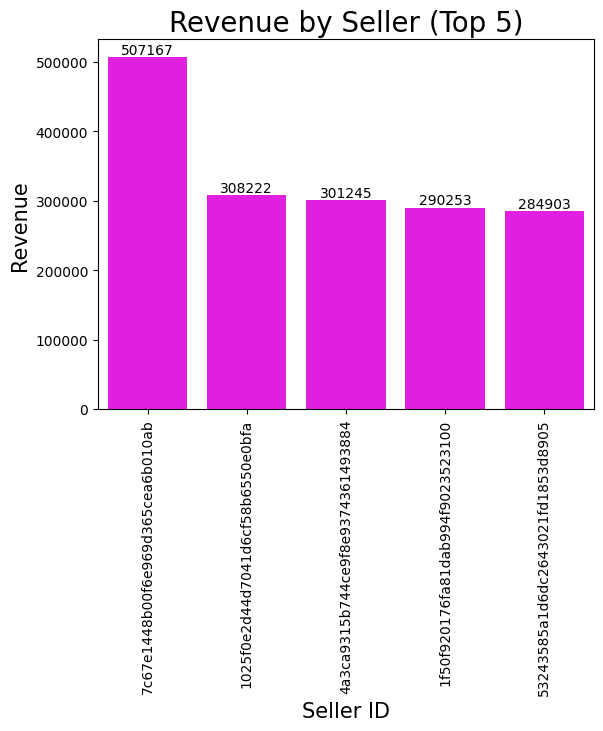

In [14]:
query = """SELECT 
	oi.seller_id, ROUND(SUM(payment_value),2) AS seller_revenue,
    DENSE_RANK() OVER(ORDER BY SUM(payment_value) DESC) AS seller_rank
FROM order_items oi
JOIN payments p ON p.order_id = oi.order_id
GROUP BY oi.seller_id;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["seller_id", "revenue", "rank"])
df = df.head()

ax = sns.barplot(x = df["seller_id"],y =  df["revenue"], data = df, color = "magenta")
ax.bar_label(ax.containers[0])
plt.xticks(rotation = 90)
plt.xlabel("Seller ID", size = 15)
plt.ylabel("Revenue", size = 15)
plt.title("Revenue by Seller (Top 5)", size = 20)
plt.show()





# Advance Queries

## 1. Calculate the moving average of order values for each customer over their order history.
(say moving average of last 3 orders) 


In [15]:
query = """SELECT 
t.customer_id, t.order_purchase_timestamp, t.payment_value, customer_order_count, moving_avg_3_orders
FROM(SELECT 
	o.customer_id, o.order_purchase_timestamp, p.payment_value,
    COUNT(*) OVER (PARTITION BY o.customer_id) AS customer_order_count,
    ROUND(AVG(p.payment_value)OVER(PARTITION BY o.customer_id ORDER BY o.order_purchase_timestamp ROWS 
    BETWEEN 2 PRECEDING AND CURRENT ROW),2)  AS moving_avg_3_orders
	FROM orders o 
    JOIN payments p ON p.order_id = o.order_id) AS t
WHERE customer_order_count > 1
-- customers with More than 1 order will be filtered in this data and 
-- hence moving average will be calculated as per 2, 3, 4 or more orders
;"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["customer_id", "order_purchase_timestamp", "payment_value","customer_order_count","moving_avg_3_orders"])
df


,customer_id,order_purchase_timestamp,payment_value,customer_order_count,moving_avg_3_orders
0,000e943451fc2788ca6ac98a682f2f49,2017-04-20 19:37:14,26.80,4,26.80
1,000e943451fc2788ca6ac98a682f2f49,2017-04-20 19:37:14,26.80,4,26.80
2,000e943451fc2788ca6ac98a682f2f49,2017-04-20 19:37:14,25.83,4,26.48
3,000e943451fc2788ca6ac98a682f2f49,2017-04-20 19:37:14,26.80,4,26.48
4,001051abfcfdbed9f87b4266213a5df1,2018-05-30 09:19:31,13.35,3,13.35
...,...,...,...,...,...
7402,fff3a5c6d542d52b05f7e4518adf996e,2018-02-18 21:48:22,33.27,3,19.30
7403,fff3a5c6d542d52b05f7e4518adf996e,2018-02-18 21:48:22,44.63,3,27.74
7404,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,9.49,3,9.49
7405,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,71.23,3,40.36


## 2. Calculate the cumulative sales per month for each year. 

In [16]:
query = """WITH monthly_sales AS (
SELECT 
	YEAR(o.order_purchase_timestamp) AS year, MONTH(o.order_purchase_timestamp) AS month_num, MONTHNAME(o.order_purchase_timestamp) AS month,
    ROUND(SUM(p.payment_value),2) AS monthly_sales
FROM orders o 
JOIN payments p ON p.order_id = o.order_id
GROUP BY year, month_num, month
ORDER BY year, month_num
)
SELECT 
	year, month, monthly_sales,
    ROUND(SUM(monthly_sales) OVER(ORDER BY year, month_num),2) AS monthly_cumulative_sales    
    FROM monthly_sales;"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["year", "month", "monthly_sales","monthly_cumulative_sales"])
df

,year,month,monthly_sales,monthly_cumulative_sales
0,2016,September,252.24,252.24
1,2016,October,59090.48,59342.72
2,2016,December,19.62,59362.34
3,2017,January,138488.04,197850.38
4,2017,February,291908.01,489758.39
5,2017,March,449863.60,939621.99
6,2017,April,417788.03,1357410.02
7,2017,May,592918.82,1950328.84
8,2017,June,511276.38,2461605.22
9,2017,July,592382.92,3053988.14


## 3. Calculate the year-over-year growth rate of total sales.

In [17]:
query = """SELECT 
	year, yearly_sales, previous_year_sales,
    ROUND((yearly_sales - previous_year_sales)*100/previous_year_sales,2) AS YoY_growth_percent
FROM (SELECT 
		YEAR(o.order_purchase_timestamp) AS year, ROUND(SUM(p.payment_value),2) AS yearly_sales,
		LAG(ROUND(SUM(p.payment_value),2),1) OVER(ORDER BY YEAR(o.order_purchase_timestamp)) AS previous_year_sales
		FROM orders o
		JOIN payments p ON p.order_id = o.order_id
		GROUP BY year) AS year_sale;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["year", "yearly_sales","previous_year_sales","YoY_growth_percent"])
df

,year,yearly_sales,previous_year_sales,YoY_growth_percent
0,2016,59362.34,NaN,NaN
1,2017,7249746.73,59362.34,12112.7
2,2018,8699763.05,7249746.73,20.0


## 4. Calculate the month-on-month growth rate of total sales. 

In [18]:
query = """WITH monthly_sales AS (
SELECT 
	YEAR(o.order_purchase_timestamp) AS year, MONTH(o.order_purchase_timestamp) AS month_num, MONTHNAME(o.order_purchase_timestamp) AS month,
    ROUND(SUM(p.payment_value),2) AS monthly_sales
FROM orders o 
JOIN payments p ON p.order_id = o.order_id
GROUP BY year, month_num, month
ORDER BY year, month_num
)
SELECT 
	year, month, monthly_sales,
    LAG(monthly_sales,1) OVER(ORDER BY year, month_num) AS prev_month_sale,
    ROUND((monthly_sales - LAG(monthly_sales,1) OVER(ORDER BY year, month_num))*100/LAG(monthly_sales,1) OVER(ORDER BY year, month_num),2) AS
    Mom_growth
    FROM monthly_sales;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["year", "month","monthly_sales","prev_month_sale","Mom_growth"])
df

,year,month,monthly_sales,prev_month_sale,Mom_growth
0,2016,September,252.24,NaN,NaN
1,2016,October,59090.48,252.24,23326.29
2,2016,December,19.62,59090.48,-99.97
3,2017,January,138488.04,19.62,705751.38
4,2017,February,291908.01,138488.04,110.78
5,2017,March,449863.60,291908.01,54.11
6,2017,April,417788.03,449863.60,-7.13
7,2017,May,592918.82,417788.03,41.92
8,2017,June,511276.38,592918.82,-13.77
9,2017,July,592382.92,511276.38,15.86


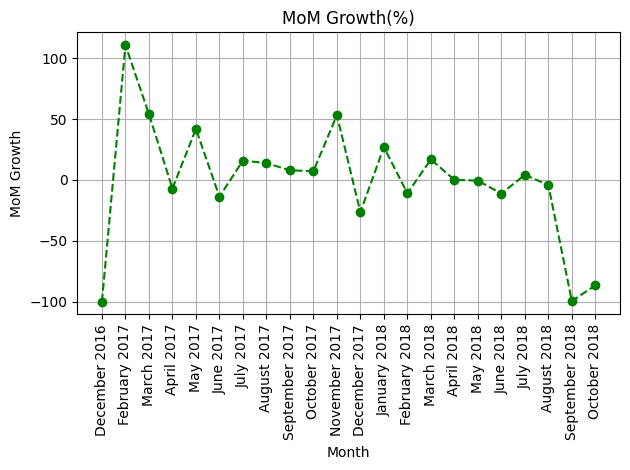

In [19]:
#A line chart for above data

#attachineyear and month first in dataframe as a combined column
df['month_label'] = df['month'] + ' ' + df['year'].astype(str)

# to exclude outliers, filtering the dataframe
filtered_df = df[df['Mom_growth'] <= 150].copy()

# Create combined month labels
filtered_df['month_label'] = filtered_df['month'] + ' ' + filtered_df['year'].astype(str)

plt.plot(filtered_df['month_label'], filtered_df['Mom_growth'], color='green', marker='o', linestyle='--')

plt.xlabel('Month')
plt.ylabel('MoM Growth')
plt.title('MoM Growth(%)')
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

## 5. Identify the top 3 customers who spent the most money in each year. 


In [20]:
query = """WITH customer_spending AS (SELECT 
	YEAR(o.order_purchase_timestamp) AS year,
    o.customer_id, ROUND(SUM(p.payment_value),2) AS spent,
    -- Don't partition by customer_id because then every customer will be assigned a new group and respective rank i.e. 1
    DENSE_RANK() OVER(PARTITION BY YEAR(o.order_purchase_timestamp) ORDER BY ROUND(SUM(p.payment_value),2) DESC) AS customer_rank_in_year
FROM orders o
JOIN payments p ON p.order_id = o.order_id
GROUP BY year, o.customer_id
ORDER BY year)
SELECT 
	year, customer_id, spent, customer_rank_in_year
FROM customer_spending
WHERE customer_rank_in_year <= 3;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["year","customer_id","spent","customer_rank_in_year"])
df

,year,customer_id,spent,customer_rank_in_year
0,2016,a9dc96b027d1252bbac0a9b72d837fc6,1423.55,1
1,2016,1d34ed25963d5aae4cf3d7f3a4cda173,1400.74,2
2,2016,4a06381959b6670756de02e07b83815f,1227.78,3
3,2017,1617b1357756262bfa56ab541c47bc16,13664.08,1
4,2017,c6e2731c5b391845f6800c97401a43a9,6929.31,2
5,2017,3fd6777bbce08a352fddd04e4a7cc8f6,6726.66,3
6,2018,ec5b2ba62e574342386871631fafd3fc,7274.88,1
7,2018,f48d464a0baaea338cb25f816991ab1f,6922.21,2
8,2018,e0a2412720e9ea4f26c1ac985f6a7358,4809.44,3


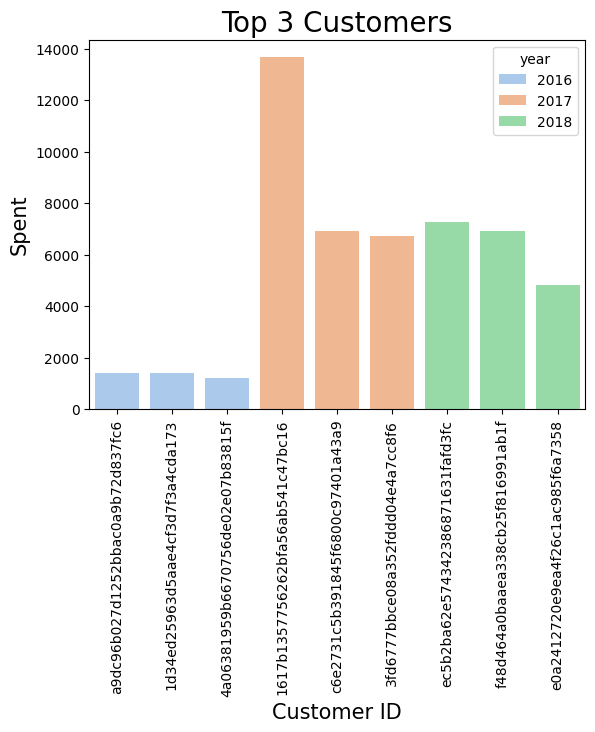

In [21]:
sns.barplot(x = "customer_id", y = "spent", data = df, hue = "year", palette= "pastel")
plt.xticks(rotation = 90)
plt.xlabel("Customer ID", size = 15)
plt.ylabel("Spent", size = 15)
plt.title("Top 3 Customers", size = 20)
plt.show()